18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing



Correlation Table:
+------+--------------------+--------------------+
|      |        MSFT        |        AAPL        |
+------+--------------------+--------------------+
| MSFT |        1.0         | 0.9515985343355651 |
| AAPL | 0.9515985343355651 |        1.0         |
+------+--------------------+--------------------+


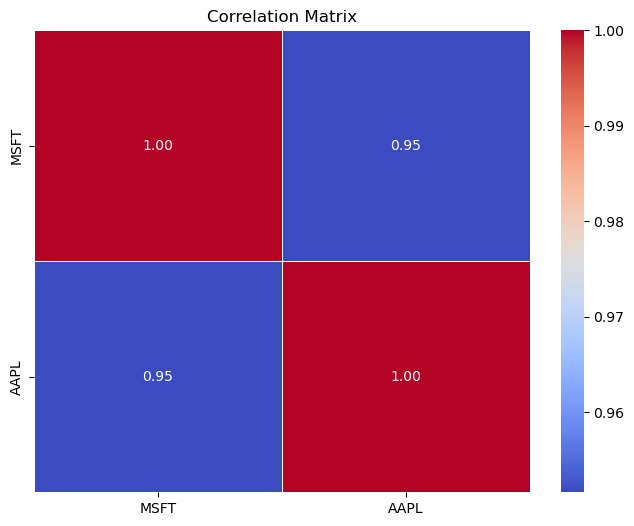

In [109]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from prophet import Prophet
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from datetime import datetime, timedelta

def fetch_stock_data(ticker, start_date, end_date):
    """Fetch historical stock data for the given ticker from Yahoo Finance.

    Args:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date for historical data (YYYY-MM-DD).
        end_date (str): End date for historical data (YYYY-MM-DD).

    Returns:
        pandas.DataFrame: DataFrame containing the historical stock data.
    """
    return yf.download(ticker, start=start_date, end=end_date, progress=False)

# Calculate start_date as today - 4 years
start_date = (datetime.today() - timedelta(days=4*365)).strftime('%Y-%m-%d')

# Ask the user to input the tickers (comma-separated)
tickers_input = input("Enter the tickers (comma-separated): ")
tickers = [ticker.strip().upper() for ticker in tickers_input.split(",")]

# Create an empty list to store the traces for each ticker
all_traces = []

# Create a DataFrame to store the closing prices of all tickers
closing_prices_df = pd.DataFrame()

# Loop through each ticker to fetch data and create traces
for ticker in tickers:
    # Fetch historical stock data for the current ticker
    stock_data = fetch_stock_data(ticker, start_date, end_date=datetime.today().strftime('%Y-%m-%d'))

    # Add the closing prices of the current ticker to the DataFrame
    closing_prices_df[ticker] = stock_data["Close"]

    # Prepare the data for Prophet
    prophet_data = stock_data.reset_index()[["Date", "Close"]]
    prophet_data.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)

    # Create and fit the Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_data)

    # Make future predictions using the Prophet model
    future = model.make_future_dataframe(periods=365)  # 30 days forecast
    forecast = model.predict(future)

    # Calculate Bollinger Bands
    window = 20
    std_dev = 2
    stock_data["MA"] = stock_data["Close"].rolling(window=window).mean()
    stock_data["Upper"] = stock_data["MA"] + std_dev * stock_data["Close"].rolling(window=window).std()
    stock_data["Lower"] = stock_data["MA"] - std_dev * stock_data["Close"].rolling(window=window).std()

    # Identify bearish and bullish signals
    bullish_signals = stock_data[stock_data["Close"] > stock_data["Upper"]]["Close"]
    bearish_signals = stock_data[stock_data["Close"] < stock_data["Lower"]]["Close"]

    # Create traces for each ticker
    traces = [
        go.Scatter(x=stock_data.index, y=stock_data["Upper"], mode="lines", name=f"{ticker} Upper Bollinger Band", line=dict(color="blue")),
        go.Scatter(x=stock_data.index, y=stock_data["Lower"], mode="lines", name=f"{ticker} Lower Bollinger Band", line=dict(color="blue")),
        go.Scatter(x=stock_data.index, y=stock_data["Close"], mode="lines", name=f"{ticker} Closing Price", line=dict(color="black")),
        go.Scatter(x=forecast["ds"], y=forecast["yhat"], mode="lines", name=f"{ticker} Prophet Forecast", line=dict(color="purple")),
        go.Scatter(x=bullish_signals.index, y=bullish_signals, mode="markers", name=f"{ticker} Bullish Signal", marker=dict(symbol="triangle-up", size=10, color="green")),
        go.Scatter(x=bearish_signals.index, y=bearish_signals, mode="markers", name=f"{ticker} Bearish Signal", marker=dict(symbol="triangle-down", size=10, color="red")),
        go.Scatter(x=forecast["ds"], y=forecast["trend"], mode="lines", name=f"{ticker} Trend Line", line=dict(color="orange", dash="dash"))
    ]

    # Add the traces for the current ticker to the list of all traces
    all_traces.extend(traces)

# Create a Plotly figure with all the traces
fig = go.Figure(data=all_traces)

# Update the layout to accommodate the secondary y-axis
fig.update_layout(
    title="Multiple Tickers - Bollinger Bands, Prophet Forecast, and Bullish/Bearish Signals",
    xaxis_title="Date",
    template="plotly_white"
)

# Show the chart
fig.show()

# Calculate the correlation between the closing prices of the stocks
correlation_df = closing_prices_df.corr()

# Calculate the Pearson correlation coefficient and p-value
pearson_corr, pearson_p_value = pearsonr(closing_prices_df[tickers[0]], closing_prices_df[tickers[1]])

# Calculate the Spearman correlation coefficient and p-value
spearman_corr, spearman_p_value = closing_prices_df[tickers].corr(method='spearman').iloc[0, 1], None

# Print the correlation table in a visually appealing format
print("\nCorrelation Table:")
print(tabulate(correlation_df, headers='keys', tablefmt='pretty'))

# Print the Pearson and Spearman correlation coefficients in a nice table
correlation_data = [
    ["Pearson Correlation", f"{pearson_corr:.4f}"],
    ["Spearman Correlation", f"{spearman_corr:.4f}"]
]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
